# Analisi di serie temporali sull'andamento della camminata

## Descrizione :

I file che hanno :

- *_P_* sono il cammino sulle punte, 
- *_N_* sono per il cammino normale
- *_TP_* sono per tacco-punta. 
     
Ciascun file csv è una matrice Nx75.
N è il numero di campioni (frame del video). 

Nelle colonne ci sono in ordine x |y| likelihood ( dove la likelihood è un numero tra 0 e 1 che esprime quanto siamo sicuri di aver trovato il giunto nella posizione giusta) 
di ogni giunto trovato sul piano immagine (per un totale di 25 punti).

L'ordine dei punti è il seguente: 0.naso, 1.torace, 2.spalla dx, 3.gomito dx, 4.polso dx, 5.spalla sx, 6.gomito sx, 7.polso sx, 8.cresta iliaca, 9.anca dx, 10.ginocchio dx, 11.caviglia dx, 12.anca sx, 13.ginocchio sx, 14.caviglia sx, 15.occhio dx, 16.occhio sx, 17.zigomo dx, 18.zigomo sx, 19,20,21.piede sx, 22,23,24.piede dx.

Qundi avrete come prima colonna la x del naso, seconda colonna la y del naso e cosi via. 

La likelihood è un numero tra 0 e 1 che esprime quanto siamo sicuri di aver trovato il giunto nella posizione giusta questa informazione interessa fino ad un certo punto percio potete non considerare le colonne multipli di 3 e via.
Come dicevamo i giunti più importanti saranno quelli sulle gambe e il polso. Vi consiglio di plottare la x del naso come prima cosa per capire un pochino di che cosa si parla.
Come dicevamo i dati non sono filtrati e forse un minimo di filtraggio ci sta ma vedete voi. Per qualsiasi cosa se non fossi stato chiaro ci sono per parlarne

In [1]:
import pandas as pd
import tstools.plot as ts_plot
import tstools.data_manipulation as ts_data

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as sft

import sys
sys.path.insert(1, '../../../python_modules')
import helper as helper
import project_analysis as analysis



## Manipolazione dei Dati del paziente sano S008 con camminata normale

In [2]:
# read the dataset
dataset_path = '../../datasets/008/S008_TP_2.csv'
dataset = pd.read_csv(dataset_path)

In [3]:
display(dataset.head())
print('[--] shape: N={} | M={}'.format(dataset.shape[0], dataset.shape[1]))

,NaN,NaN.1,NaN.2,NaN.3,NaN.4,NaN.5,NaN.6,NaN.7,NaN.8,NaN.9,...,NaN.56,1170.6,707.8,0.61028,1175.8,702.61,0.58635,1241.6,715.73,0.44805
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.9,705.16,0.52222,1170.5,702.47,0.48914,1238.9,707.85,0.27442
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.8,705.18,0.55417,1168.0,702.49,0.52905,1239.0,715.69,0.31926
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.9,705.19,0.53134,1170.6,702.54,0.50617,1246.7,720.89,0.28784
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1170.6,710.41,0.54067,1175.8,705.20,0.51820,1249.4,718.34,0.37098
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[--] shape: N=2883 | M=75


### Rinominazione delle colonne

Possiamo notare come i nomi delle colonne della serie non sono corretti quindi rinominiamole assegnando dei nomi significativi per quello che effettivamente rappresentano

In [4]:

helper.rename_columns(dataset)
dataset.head()

,x_naso,y_naso,l_naso,x_torace,y_torace,l_torace,x_spalla_dx,y_spalla_dx,l_spalla_dx,x_gomito_dx,...,l_piede_sx_3,x_piede_dx_1,y_piede_dx_1,l_piede_dx_1,x_piede_dx_2,y_piede_dx_2,l_piede_dx_2,x_piede_dx_3,y_piede_dx_3,l_piede_dx_3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.9,705.16,0.52222,1170.5,702.47,0.48914,1238.9,707.85,0.27442
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.8,705.18,0.55417,1168.0,702.49,0.52905,1239.0,715.69,0.31926
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1167.9,705.19,0.53134,1170.6,702.54,0.50617,1246.7,720.89,0.28784
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1170.6,710.41,0.54067,1175.8,705.20,0.51820,1249.4,718.34,0.37098
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Eliminazione valori nulli

Controlliamo ora se il dataset contiene dei valori nulli

In [5]:
display(ts_data.count_null(dataset))

,x_naso,y_naso,l_naso,x_torace,y_torace,l_torace,x_spalla_dx,y_spalla_dx,l_spalla_dx,x_gomito_dx,...,l_piede_sx_3,x_piede_dx_1,y_piede_dx_1,l_piede_dx_1,x_piede_dx_2,y_piede_dx_2,l_piede_dx_2,x_piede_dx_3,y_piede_dx_3,l_piede_dx_3
0,881,881,881,784,784,784,812,812,812,1298,...,847,818,818,818,874,874,874,804,804,804


Come possiamo vedere il dataset contiene molti valori nulli, probabilmente dovuti al fatto che la fotocamera in quei punti non è riuscita ad ottenere nessuna informazione riguardante il giunto considerato dovuto al fatto che il soggetto è uscito dall'inquadratura.

Essendo che possiamo anche non considerare i momenti in cui il soggetto non è presente nell'inquadratura possiamo eliminare i valori nulli.

In [6]:
dataset = helper.delete_nan_from_DataFrame(dataset)
dataset.head()

,x_naso,y_naso,l_naso,x_torace,y_torace,l_torace,x_spalla_dx,y_spalla_dx,l_spalla_dx,x_gomito_dx,...,l_piede_sx_3,x_piede_dx_1,y_piede_dx_1,l_piede_dx_1,x_piede_dx_2,y_piede_dx_2,l_piede_dx_2,x_piede_dx_3,y_piede_dx_3,l_piede_dx_3
0,1270.5,234.47,0.39876,1296.9,271.31,0.068281,1296.8,266.10,0.20560,1273.1,...,0.358620,1167.9,705.16,0.52222,1170.5,702.47,0.48914,1238.9,707.85,0.27442
1,1267.8,239.74,0.70205,1296.8,263.41,0.321610,1296.8,268.70,0.33711,1270.5,...,0.070928,1167.8,705.18,0.55417,1168.0,702.49,0.52905,1239.0,715.69,0.31926
2,1257.3,237.17,0.68262,1296.8,263.54,0.374360,1296.8,263.55,0.31496,1267.9,...,0.102730,1167.9,705.19,0.53134,1170.6,702.54,0.50617,1246.7,720.89,0.28784
3,1252.1,239.75,0.83404,1296.8,266.06,0.415170,1275.8,268.70,0.36207,1262.6,...,0.215390,1170.6,710.41,0.54067,1175.8,705.20,0.51820,1249.4,718.34,0.37098
4,1249.4,239.70,0.84393,1296.8,266.04,0.560960,1273.1,268.72,0.49734,1254.7,...,0.245510,1178.4,715.72,0.40033,1181.0,707.84,0.38869,1252.0,718.31,0.24754


In [7]:
dataset.tail()

,x_naso,y_naso,l_naso,x_torace,y_torace,l_torace,x_spalla_dx,y_spalla_dx,l_spalla_dx,x_gomito_dx,...,l_piede_sx_3,x_piede_dx_1,y_piede_dx_1,l_piede_dx_1,x_piede_dx_2,y_piede_dx_2,l_piede_dx_2,x_piede_dx_3,y_piede_dx_3,l_piede_dx_3
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dato che le serie dei dataframe di pandas hanno tutte stessa lunghezza e nel nostro caso dopo che vengono tolti i valori nulli le serie hanno lunghezza differente alla fine di praticamente ogni serie si troveranno dei valori nulli (tanti quanti la differenza tra la serie piu lunga del dataset e la serie che stiamo considerando) che andranno eliminati in fase di analisi.

### Smoothing / Filtering

Se guardiamo le varie serie possiamo notare come i dati contengano molta noise, per questa ragione cerchiamo di fare dello smoothing per ottenere dei dati un po' più omogenei.

In [8]:
# ts_plot.plot_all(dataset)

In [9]:
dataset_smoothed = analysis.smooth_dataframe(dataset)

In [10]:
# ts_plot.plot_all(dataset_smoothed)

Una pratica migliore per ridurre l'effetto della noise è quello di poter filtrare le serie nello spazio delle frequenze

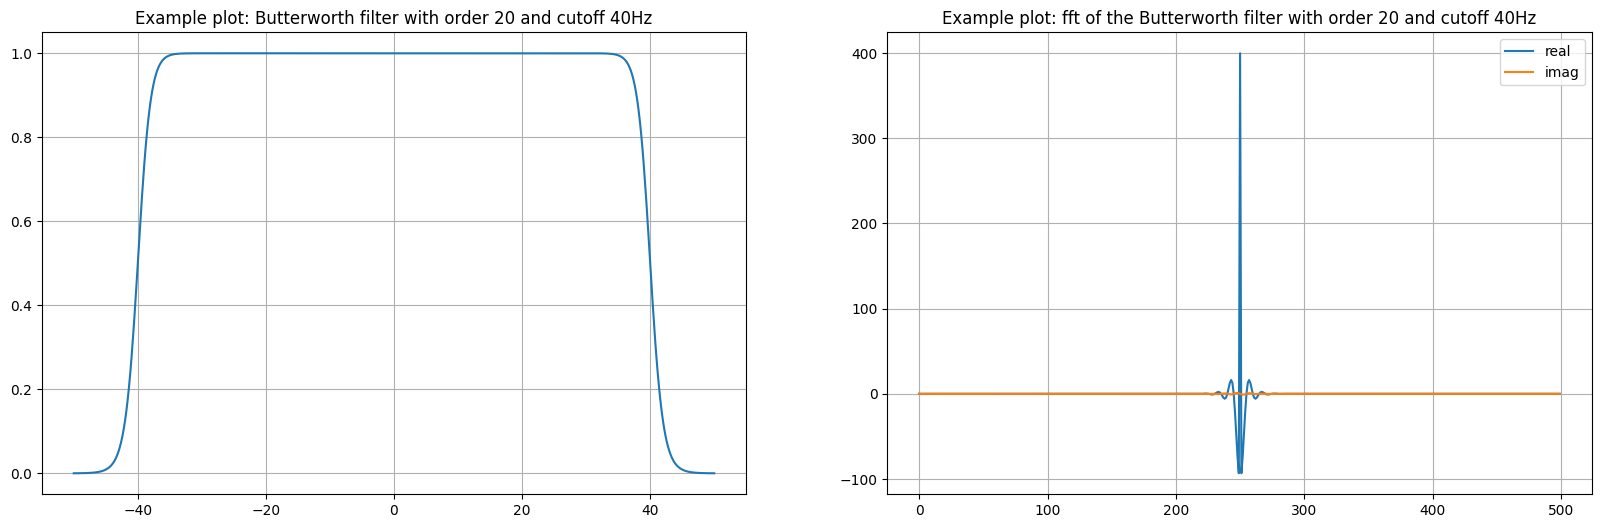

In [11]:
# a simple plot of the filter
x = np.linspace(start=-50, stop=50, num=500)
y = analysis.low_pass_filter(x, 20, 40)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Example plot: Butterworth filter with order 20 and cutoff 40Hz')
plt.grid()
plt.plot(x, y)


b_fft = sft.fft(y)

plt.subplot(1,2,2)
plt.title('Example plot: fft of the Butterworth filter with order 20 and cutoff 40Hz')
plt.plot(sft.fftshift(b_fft.real), label='real')
plt.plot(sft.fftshift(b_fft.imag), label='imag')
plt.legend()
plt.grid()

In [12]:
dataset_filtered = analysis.filter_dataframe(dataset, filter_n_order=20, filter_cutoff_freq=25)

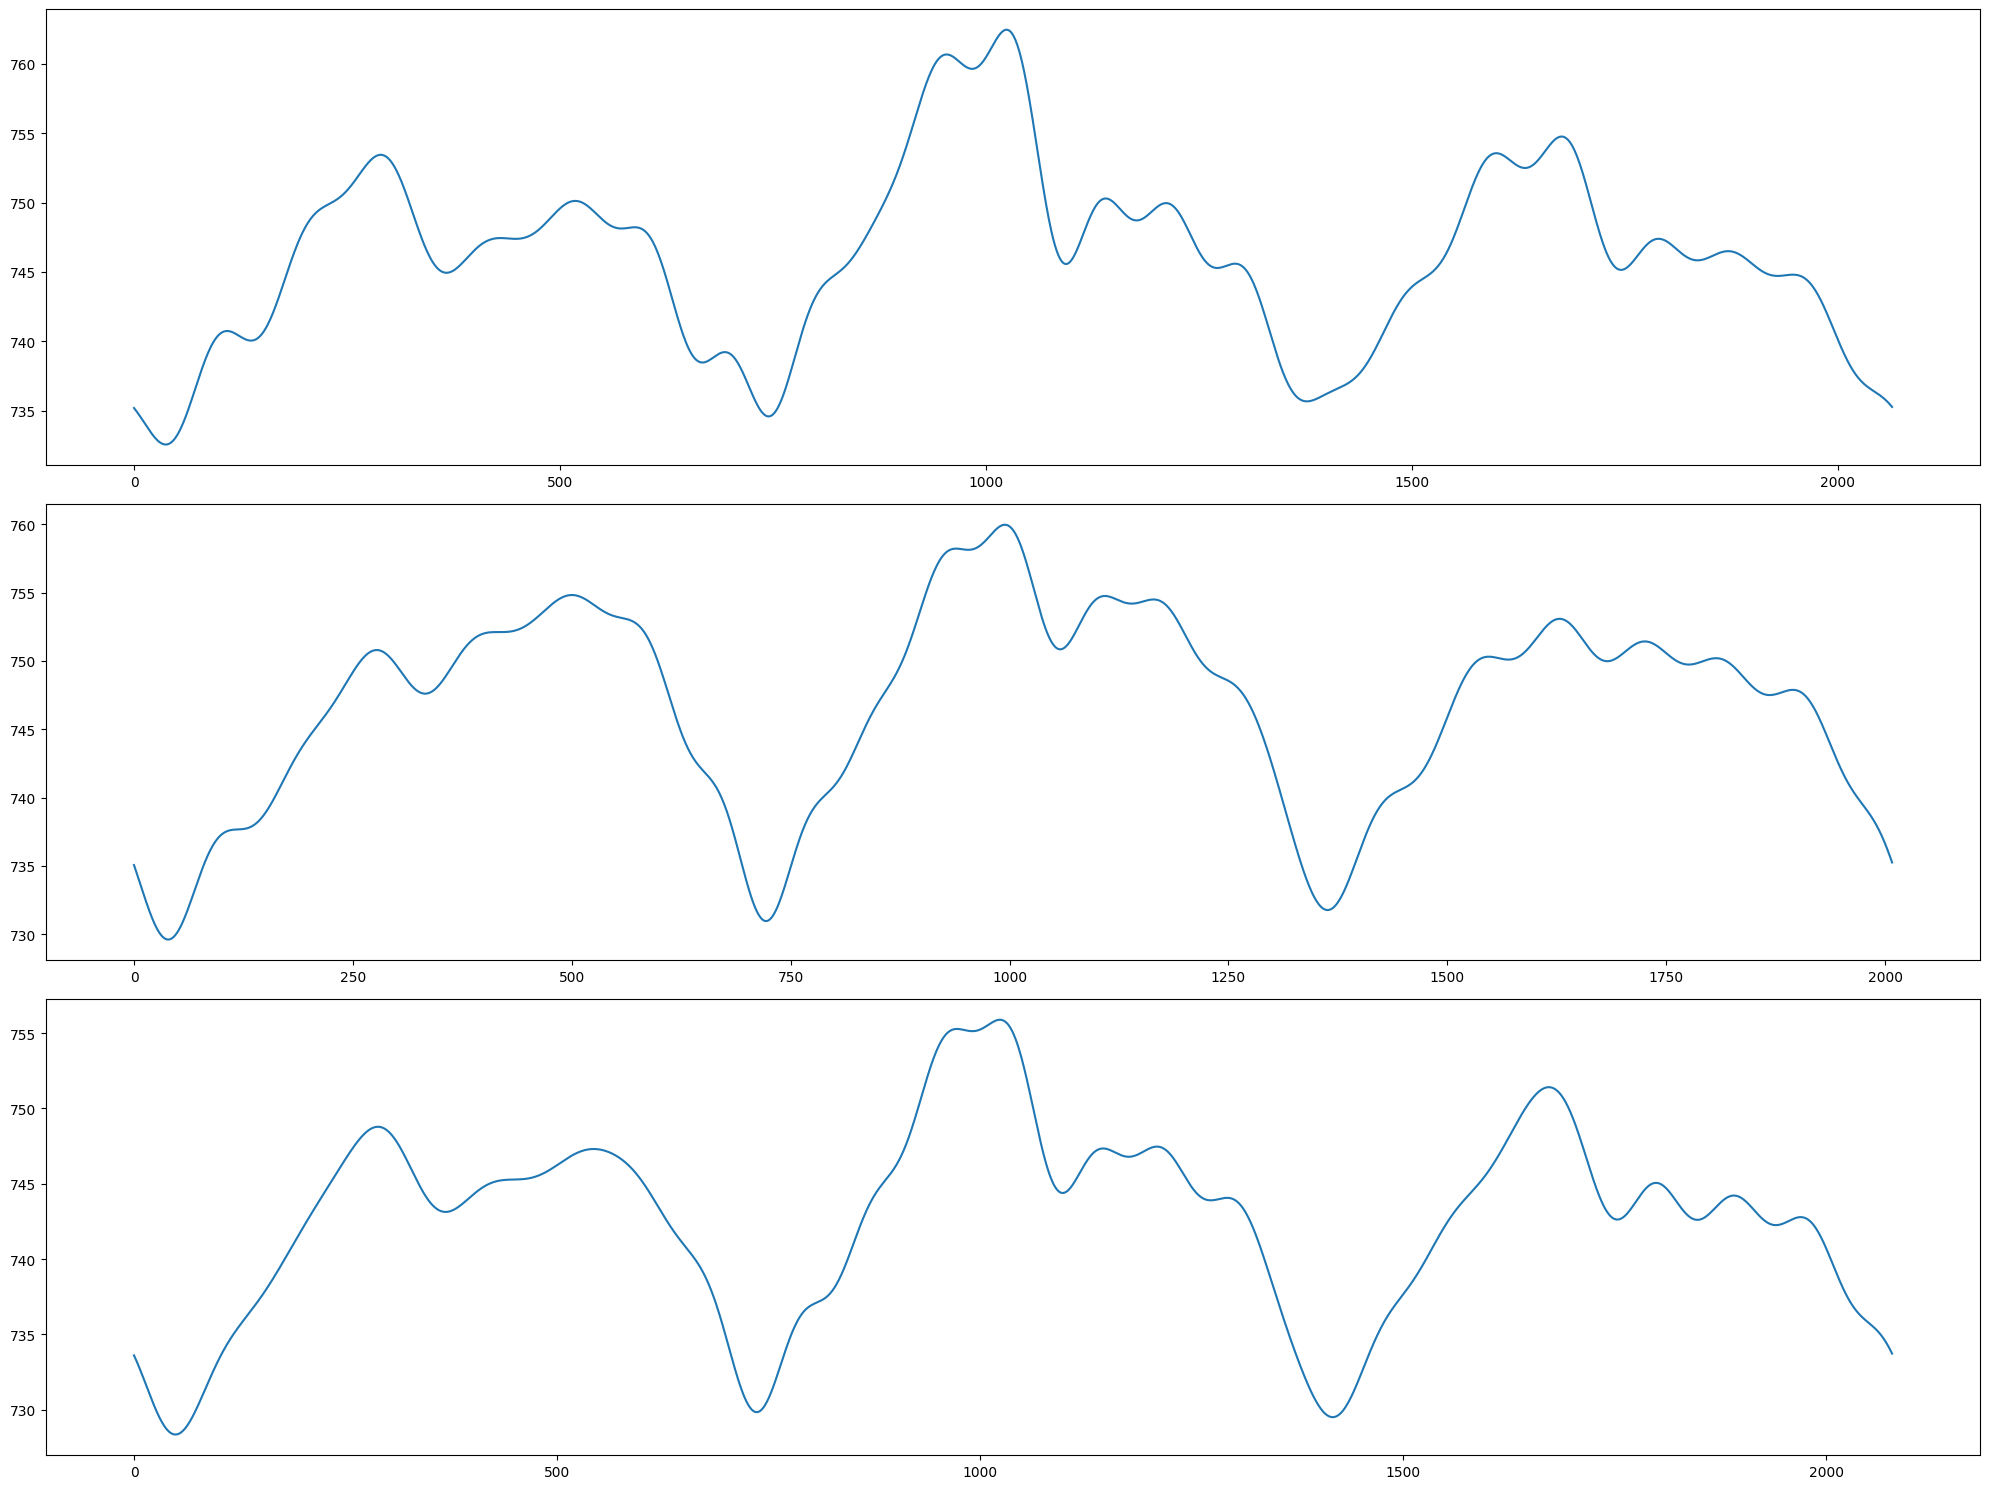

In [13]:
# ts_plot.plot_all(dataset_filtered)
ts_plot.plot_multiple([dataset_filtered.y_piede_dx_1, dataset_filtered.y_piede_dx_2, dataset_filtered.y_piede_dx_3])

In [14]:
# Usaimo la libreria scipy per filtrare
ypdx = dataset.y_piede_dx_1

from scipy import signal as s

fs = 30

cutoff_freq = 25
order = 20
b, a = s.butter(order, 30 / len(ypdx))

Esportiamo ora il dataset filtrato così da potermlo utilizzare nella fase di analisi

In [15]:
dataset_filtered.to_csv('S008_TP_2-filtered.csv', index=False)